In [ ]:
pip install boruta

In [2]:
from boruta import BorutaPy

In [3]:
import pandas as pd
import os
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import math 

from sklearn.utils import safe_sqr
from sklearn.base import clone
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV, RFE

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import LassoCV, Lasso

from sklearn.metrics import r2_score
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd

X = df.drop(columns=['sample', 'ages'])  
y = df['ages']  

k = 2000  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X, y)

# Get the names of the selected features
selected_feature_names = X.columns[selector.get_support()]

In [ ]:
selected_features_df = pd.DataFrame(selected_feature_names, columns=['Selected_CpGs'])

selected_features_df.to_csv('SelectKBest2000_cpgs.csv', index=False)

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

X_selected = X[selected_feature_names]

rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=1)

boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',        # Automatically find the optimal number of trees
    max_iter=200,               # Increase the number of iterations
    perc=90,                    # Use a stringent percentile (90th)
    verbose=2,
    random_state=1
)

boruta_selector.fit(X_selected.values, y.values)

final_selected_features = X_selected.columns[boruta_selector.support_]

tentative_features = X_selected.columns[boruta_selector.support_weak_]

In [ ]:
features_df = pd.DataFrame({
    'Feature': list(final_selected_features) + list(tentative_features),
    'Status': ['Confirmed'] * len(final_selected_features) + ['Tentative'] * len(tentative_features)
})

# Save the DataFrame to a CSV file
features_df.to_csv('boruta_selected_features.csv', index=False)

In [140]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

In [ ]:
X = df[final_selected_features]  
y = df['ages']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

elastic_net = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1],  
                           n_alphas=100,  
                           cv=5,  
                           random_state=42)

elastic_net.fit(X_train, y_train)

y_pred = elastic_net.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

cv_scores = cross_val_score(elastic_net, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-np.mean(cv_scores):.2f}")



predicted_ages = elastic_net.predict(X)


df['Predicted_Age'] = predicted_ages

print(df[['sample', 'ages', 'Predicted_Age']])

In [ ]:
import pandas as pd

# Calculate Age Acceleration
df['Age_Acceleration'] = df['Predicted_Age'] - df['ages']

print(df[['sample', 'ages', 'Predicted_Age', 'Age_Acceleration']])


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['ages'], y=df['Predicted_Age'], hue=df['Age_Acceleration'], palette="coolwarm", edgecolor="black")
plt.plot([df['ages'].min(), df['ages'].max()], [df['ages'].min(), df['ages'].max()], 'k--', lw=2) 
plt.title('Age vs. Predicted Age with Age Acceleration')
plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Histogram of Age Acceleration
sns.histplot(df['Age_Acceleration'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age Acceleration')
plt.xlabel('Age Acceleration')
plt.ylabel('Frequency')

plt.show()

In [72]:
import pandas as pd

df['feature'] = df.apply(lambda row: f"{row['seqnames']}_{row['start']}_{row['end']}", axis=1)

feature_to_symbol = df.set_index('feature')['annot.symbol'].to_dict()

selected_features_df = pd.DataFrame({
    'Feature': final_selected_features
})

selected_features_df['Gene Symbol'] = selected_features_df['Feature'].map(feature_to_symbol)

print(selected_features_df)

                      Feature Gene Symbol
0        chr1_2054820_2054820       PRKCZ
1        chr1_2115344_2115344       PRKCZ
2        chr1_2518200_2518200       PANK4
3        chr1_3727481_3727481        TP73
4        chr1_6207426_6207426       RPL22
..                        ...         ...
159   chr22_46157069_46157069       PPARA
160   chr22_49828693_49828693        BRD1
161   chr22_50571399_50571399       CPT1B
162    chrX_19344115_19344115       PDHA1
163  chrX_154355568_154355568        FLNA

[164 rows x 2 columns]


In [73]:
import pandas as pd


# Count the occurrences of each gene symbol
gene_counts = selected_features_df['Gene Symbol'].value_counts()

# Convert to DataFrame 
gene_counts_df = gene_counts.reset_index()
gene_counts_df.columns = ['Gene Symbol', 'Count']

print(gene_counts_df)

# Save the results to a CSV file
gene_counts_df.to_csv('gene_symbol_counts.csv', index=False)


    Gene Symbol  Count
0         PPM1E      5
1        PPP1CA      3
2         HOXC4      3
3         PRKCH      3
4         ADAP1      3
..          ...    ...
129        TPPP      1
130       VEGFC      1
131       ANXA3      1
132      PDGFRA      1
133        FLNA      1

[134 rows x 2 columns]


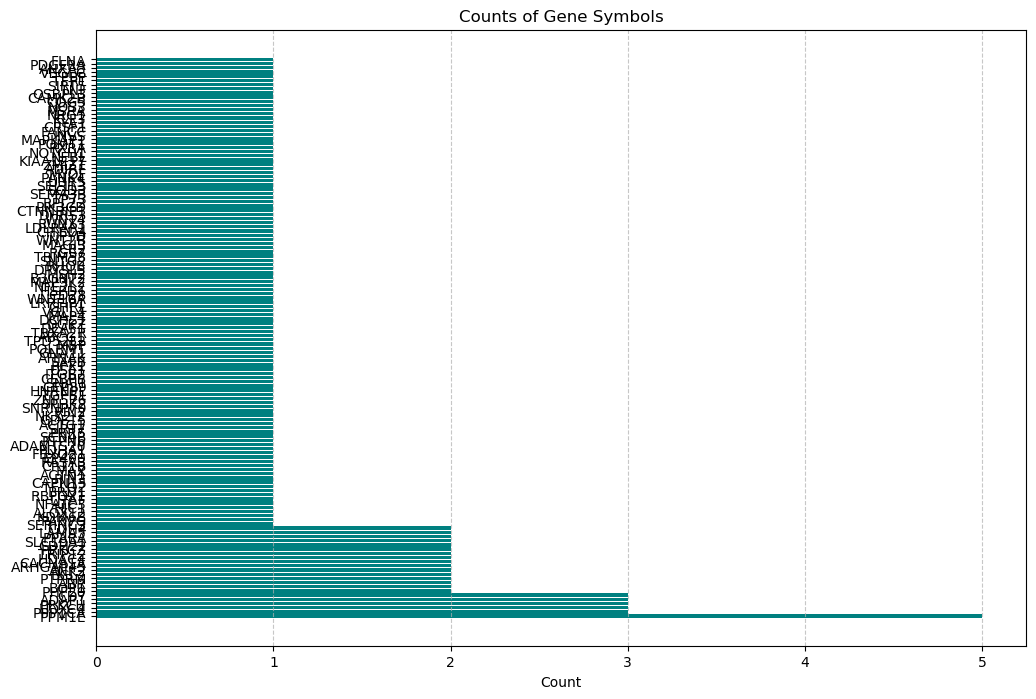

In [75]:
import pandas as pd
import matplotlib.pyplot as plt


gooddata = gene_counts_df

gooddf = pd.DataFrame(gooddata)


plt.figure(figsize=(12, 8))
plt.barh(gooddf['Gene Symbol'], gooddf['Count'], color='teal')
plt.xlabel('Count')
plt.title('Counts of Gene Symbols')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


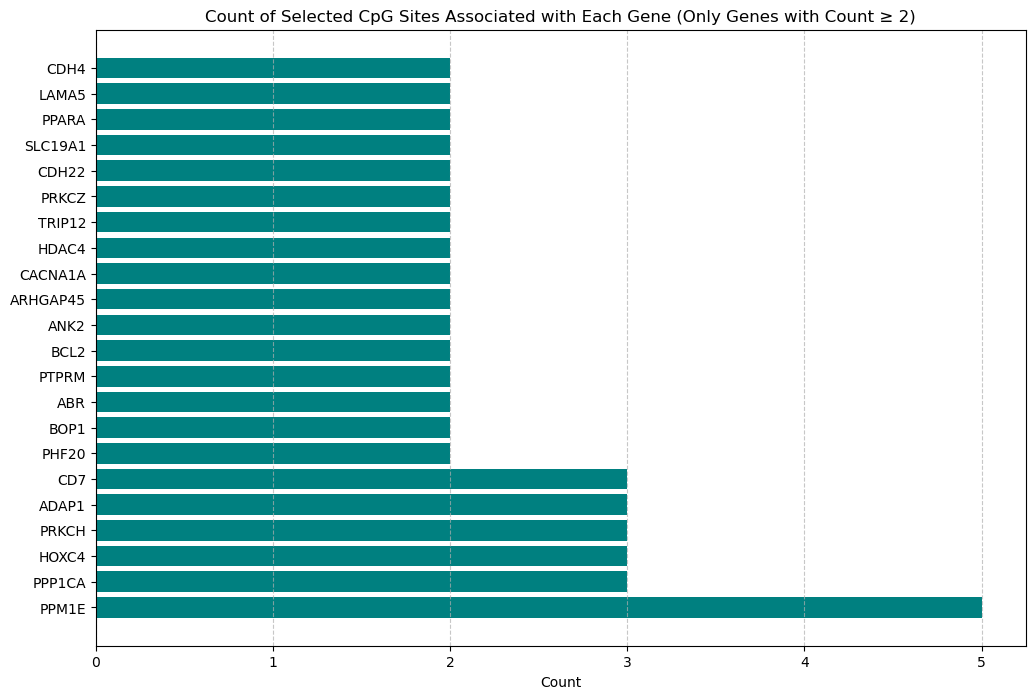

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

gooddata = gene_counts_df

gooddf = pd.DataFrame(gooddata)

filtered_df = gooddf[gooddf['Count'] >= 2]

plt.figure(figsize=(12, 8))
plt.barh(filtered_df['Gene Symbol'], filtered_df['Count'], color='teal')
plt.xlabel('Count')
plt.title('Count of Selected CpG Sites Associated with Each Gene (Only Genes with Count ≥ 2)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()